In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

%cd /content/gdrive/MyDrive/

import pandas as pd
bruno_data = pd.read_csv("DatasetsBruno/Bruno_exp2_similarity.csv")

Mounted at /content/gdrive/
/content/gdrive/MyDrive


In [2]:
%%capture
# installing dependencies
!pip install owl2vec_star
!pip install --upgrade gensim 

# importing dependencies
from configparser import DEFAULTSECT
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
import gensim
import os
# import owl2vec_star
import numpy as np
import scipy.stats as stats

In [3]:
def owl_embedding(ontology_filename):

  ontology_path = "Doccano/"
  ontology = "".join([ontology_path, ontology_filename])

  embedding_path = f"{ontology_path}{ontology_filename.split('.')[0]}-embeddings/"
  
  # downloading ontology from github repo
  !wget "https://raw.githubusercontent.com/MaastrichtU-IDS/sounds/main/ontology/{ontology_filename}" -P Doccano/ -N

  # creating embedding directory
  try: 
    os.mkdir(embedding_path)
    print(f"Directory {embedding_path} created")

  except FileExistsError:
    print(f"Directory {embedding_path} already exists")
    pass
     
  # preparing the config file
  from configparser import ConfigParser

  config_file = ConfigParser()
  config_file.read("DatasetsBruno/default.cfg")

  config_file.set(section="BASIC", option="ontology_file", value=ontology)
  config_file.set(section="BASIC", option="embedding_dir", value=embedding_path+"ontology.embeddings")
  fp=open('default.cfg','w')
  config_file.write(fp)
  fp.close()

  # ontology embedding with owl2vec
  # !git clone https://github.com/KRR-Oxford/OWL2Vec-Star.git
  # !python OWL2Vec-Star/OWL2Vec_Standalone.py --config_file default.cfg

  # loading embeddings
  model = gensim.models.Word2Vec.load(embedding_path+"ontology.embeddings")

  # creating dataframe
  lemmatizer = WordNetLemmatizer()

  if "Source" in ontology_filename:
      nouns = [lemmatizer.lemmatize(word.split()[1], pos="n") if lemmatizer.lemmatize(word.split()[1], pos="n") in model.wv.index_to_key else "" for word in bruno_data["word"]]
      verbs = [lemmatizer.lemmatize(word.split()[0], pos="v") if lemmatizer.lemmatize(word.split()[0], pos="v") in model.wv.index_to_key else "" for word in bruno_data["word"]]
      words = list(zip(nouns, verbs))

      vectors = []

      for word in words:
        try:
          v_vectors = [model.wv.get_vector(w) if word[0] + ".v." in w else model.wv.get_vector(word[0]) for w in model.wv.index_to_key]
          v_avg = sum(v_vectors) / len(v_vectors)

          n_vectors = [model.wv.get_vector(w) if word[1] + ".v." in w else model.wv.get_vector(word[1]) for w in model.wv.index_to_key]
          n_avg = sum(n_vectors) / len(n_vectors)

          vectors.append((v_avg + n_avg) / 2)

        
        except KeyError:
            if word[0] == "":
                vectors.append(model.wv.get_vector(word[1]))
            if word[1] == "":
                vectors.append(model.wv.get_vector(word[0]))

        

      df = pd.DataFrame(data=vectors, index=bruno_data["word"])

  else:
      verbs = [lemmatizer.lemmatize(word.split()[0], pos="v") for word in bruno_data["word"]]  
      filtered_verbs = [w.replace('-', '.').replace('_', '.').split(".")[0] for w in verbs if w.replace('-', '.').replace('_', '.').split(".")[0] in model.wv.index_to_key]
      #vectors = [model.wv.get_vector(w) for w in filtered_verbs if w in model.wv.index_to_key]
      
      vectors = []

      for word in filtered_verbs:
        all_vectors = [model.wv.get_vector(w) if word + ".v." in w else model.wv.get_vector(word) for w in model.wv.index_to_key]
        avg = sum(all_vectors) / len(all_vectors)
        vectors.append(avg)
      
      df = pd.DataFrame(data=vectors, index=bruno_data["word"])

  return df

In [4]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import zscore

def CSM(df):
    
    matrix = 1-squareform(pdist(df, "cosine"))
    # matrix = 1-squareform(pdist(zscore(df, axis=0), metric))

    matrix_df = pd.DataFrame(data=matrix, columns=df.index, index=df.index)
    
    return matrix_df

def upper(df):
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

In [5]:
# BERT
bert_df = pd.read_csv("DatasetsBruno/Bruno_embeddings/Bruno_SBERT_embeddings.csv")
bert_df = bert_df.set_index("Unnamed: 0")
bert_ani = CSM(bert_df[0:40])
bert_ina = CSM(bert_df[40:80])

# Word2Vec word embedding model (300 dim) 
w2vmodel = gensim.models.KeyedVectors.load_word2vec_format(
    'Datasets/GoogleNews-vectors-negative300.bin.gz', binary=True)
words = [s for s in bruno_data["word"].apply(lambda x: x.split())]
avg_vectors = [(w2vmodel.get_vector(word[0])+w2vmodel.get_vector(word[1])) / 2 for word in words if word[0] in w2vmodel.index_to_key if word[1] in w2vmodel.index_to_key]
w2v_df = pd.DataFrame(data=avg_vectors, index=bruno_data["word"])
w2v_ani = CSM(w2v_df[0:40])
w2v_ina = CSM(w2v_df[40:80])

# vggish
vgg_df = pd.read_csv("DatasetsBruno/Bruno_embeddings/Bruno_vggish_embeddings.csv")
vgg_df = vgg_df.set_index(["Unnamed: 0", "word"])
vgg_ani = CSM(vgg_df[0:40])
vgg_ina = CSM(vgg_df[40:80])

# yamnet
yamnet_df = pd.read_csv("DatasetsBruno/Bruno_embeddings/Bruno_YAMNet_embeddings.csv")
yamnet_df = yamnet_df.set_index(["Unnamed: 0", "correct_label"])
yamnet_ani = CSM(yamnet_df[0:40])
yamnet_ina = CSM(yamnet_df[40:80])

In [6]:
embedding_path = "Doccano/ultimate-sounds-WNmech-embeddings/"

model = gensim.models.Word2Vec.load(embedding_path+"ontology.embeddings")

lemmatizer = WordNetLemmatizer()
word = lemmatizer.lemmatize(bruno_data["word"][10].split()[0], pos="v")
print(word)
print("OWL2Vec class vector:")
print(model.wv.get_vector(word)[:5])

print("\nWord2Vec vector:")
print(w2vmodel.get_vector(word)[:5])

possible = [w for w in model.wv.index_to_key if word + ".v." in w]

print("\nOWL2Vec IRI vector:")

added_arrays = [0*100]
for p in possible:
  print(p)
  print(model.wv.get_vector(p)[:5])
  added_arrays = added_arrays + model.wv.get_vector(p)

vectors = [model.wv.get_vector(w) if word + ".v." in w else model.wv.get_vector(word) for w in model.wv.index_to_key]
avg = sum(vectors) / len(vectors)

print("\nAverage OWL2Vec vector:")
print(avg[:5])

print("\nAverage OWL2Vec vector:")
print(avg[:5])

call
OWL2Vec class vector:
[ 0.7964786   0.24966297 -0.37827703 -0.14431715 -0.09994075]

Word2Vec vector:
[-0.11816406  0.08154297  0.15039062  0.03100586  0.13183594]

OWL2Vec IRI vector:
http://www.w3id.org/VerbNet/call.v.23
[ 0.23641214  0.13900366  0.00446171  0.10781425 -0.3185555 ]
http://www.w3id.org/VerbNet/call.v.10
[ 0.23566027  0.15023583  0.00224407  0.10047948 -0.3751639 ]
http://www.w3id.org/VerbNet/call.v.05
[ 0.21235828  0.14460647 -0.02844955  0.10068974 -0.3536715 ]
http://www.w3id.org/VerbNet/call.v.25
[ 0.24753128  0.13306686  0.02478965  0.12487708 -0.32169595]
http://www.w3id.org/VerbNet/call.v.02
[ 1.87162086e-01  1.08290814e-01 -1.28611565e-01  1.95207467e-04
 -3.13684583e-01]

Average OWL2Vec vector:
[ 0.79606104  0.24956904 -0.37802976 -0.14415433 -0.10008341]

Average OWL2Vec vector:
[ 0.79606104  0.24956904 -0.37802976 -0.14415433 -0.10008341]


In [7]:
%%capture
nomech_ani = CSM(owl_embedding("ultimate-sounds-nomech.owl")[0:40])
nomech_ina = CSM(owl_embedding("ultimate-sounds-nomech.owl")[40:80])
nomech_ani.to_csv("DatasetsBruno/Bruno_CSM/nomech_ani.csv")
nomech_ina.to_csv("DatasetsBruno/Bruno_CSM/nomech_ina.csv")

mech_ani = CSM(owl_embedding("ultimate-sounds-WNmech.owl")[0:40])
mech_ina = CSM(owl_embedding("ultimate-sounds-WNmech.owl")[40:80])
mech_ani.to_csv("DatasetsBruno/Bruno_CSM/mech_ani.csv")
mech_ina.to_csv("DatasetsBruno/Bruno_CSM/mech_ina.csv")

mech_red_ani = CSM(owl_embedding("ultimate-sounds-WNmech-ReducedSource.owl")[0:40])
mech_red_ina = CSM(owl_embedding("ultimate-sounds-WNmech-ReducedSource.owl")[40:80])
mech_red_ani.to_csv("DatasetsBruno/Bruno_CSM/mech_red_ani.csv")
mech_red_ina.to_csv("DatasetsBruno/Bruno_CSM/mech_red_ina.csv")

mech_ful_ani = CSM(owl_embedding("ultimate-sounds-WNmech-FullSource.owl")[0:40])
mech_ful_ina = CSM(owl_embedding("ultimate-sounds-WNmech-FullSource.owl")[40:80])
mech_ful_ani.to_csv("DatasetsBruno/Bruno_CSM/mech_ful_ani.csv")
mech_ful_ina.to_csv("DatasetsBruno/Bruno_CSM/mech_ful_ina.csv")

# Transforming dissimilarity matrix into similarity matrix
bruno_ani = pd.DataFrame(data = 1-bruno_data.iloc[0:40, 4:].values, index = list(bruno_data["word"][0:40]))
bruno_ina = pd.DataFrame(data = 1-bruno_data.iloc[40:, 4:].values, index = list(bruno_data["word"][40:]))
bruno_ani.to_csv("DatasetsBruno/Bruno_CSM/bruno_ani.csv")
bruno_ina.to_csv("DatasetsBruno/Bruno_CSM/bruno_ina.csv")

In [8]:
# %%capture
# nomech_ani_nocomm = CSM(owl_embedding("ultimate-sounds-nomech-nocomm.owl")[0:40])
# nomech_ina_nocomm = CSM(owl_embedding("ultimate-sounds-nomech-nocomm.owl")[40:80])
# nomech_ani_nocomm.to_csv("DatasetsBruno/Bruno_CSM/nomech_ani_nocomm.csv")
# nomech_ina_nocomm.to_csv("DatasetsBruno/Bruno_CSM/nomech_ina_nocomm.csv")

# mech_ani_nocomm = CSM(owl_embedding("ultimate-sounds-WNmech-nocomm.owl")[0:40])
# mech_ina_nocomm = CSM(owl_embedding("ultimate-sounds-WNmech-nocomm.owl")[40:80])
# mech_ani_nocomm.to_csv("DatasetsBruno/Bruno_CSM/mech_ani_nocomm.csv")
# mech_ina_nocomm.to_csv("DatasetsBruno/Bruno_CSM/mech_ina_nocomm.csv")

# mech_red_ani_nocomm = CSM(owl_embedding("ultimate-sounds-WNmech-ReducedSource-nocomm.owl")[0:40])
# mech_red_ina_nocomm = CSM(owl_embedding("ultimate-sounds-WNmech-ReducedSource-nocomm.owl")[40:80])
# mech_red_ani_nocomm.to_csv("DatasetsBruno/Bruno_CSM/mech_red_ani_nocomm.csv")
# mech_red_ina_nocomm.to_csv("DatasetsBruno/Bruno_CSM/mech_red_ina_nocomm.csv")

# mech_ful_ani_nocomm = CSM(owl_embedding("ultimate-sounds-WNmech-FullSource-nocomm.owl")[0:40])
# mech_ful_ina_nocomm = CSM(owl_embedding("ultimate-sounds-WNmech-FullSource-nocomm.owl")[40:80])
# mech_ful_ani_nocomm.to_csv("DatasetsBruno/Bruno_CSM/mech_ful_ani_nocomm.csv")
# mech_ful_ina_nocomm.to_csv("DatasetsBruno/Bruno_CSM/mech_ful_ina_nocomm.csv")

## Embedding Visualization

--2022-09-14 08:29:32--  https://raw.githubusercontent.com/MaastrichtU-IDS/sounds/main/ontology/ultimate-sounds-WNmech-FullSource.owl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4113502 (3.9M) [text/plain]
Saving to: ‘Doccano/ultimate-sounds-WNmech-FullSource.owl’

ultimate-sounds-WNm 100%[===================>]   3.92M  --.-KB/s    in 0.1s    

Last-modified header missing -- time-stamps turned off.
2022-09-14 08:29:32 (33.9 MB/s) - ‘Doccano/ultimate-sounds-WNmech-FullSource.owl’ saved [4113502/4113502]

Directory Doccano/ultimate-sounds-WNmech-FullSource-embeddings/ already exists


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


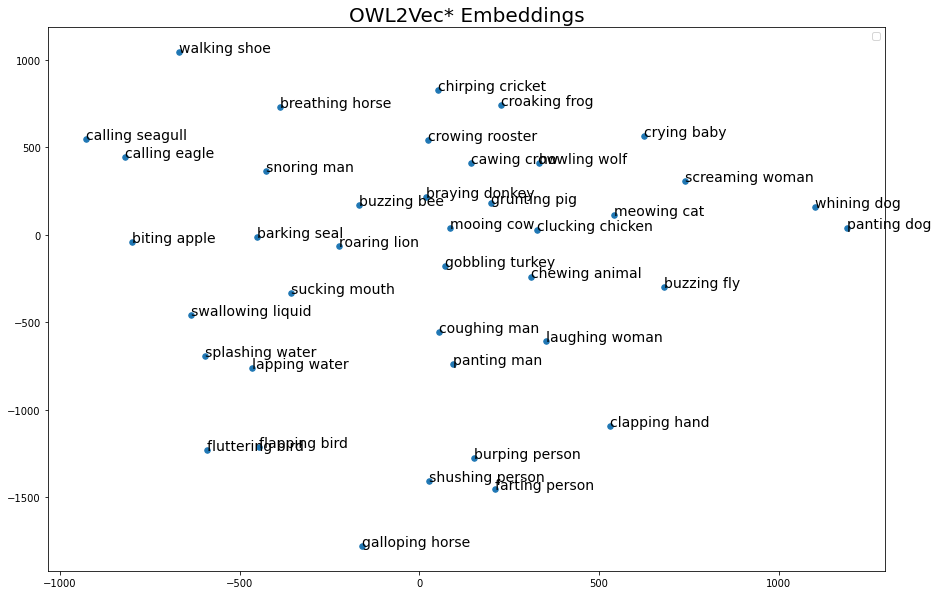

In [9]:
viz = owl_embedding("ultimate-sounds-WNmech-FullSource.owl")[0:40]

from sklearn.manifold import TSNE

tsne = TSNE(square_distances = True,
            n_components = 2,
            perplexity = 10, #25
            learning_rate = 400, #400
            init = 'random',
            metric= "cosine",
            random_state = 0)

tsne_df = tsne.fit_transform(viz)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np

fig, ax = plt.subplots(figsize = (15, 10))

# create scatterplot
scatter = plt.scatter(tsne_df[:,0],
            tsne_df[:,1],
            s=30,
            #cmap= ListedColormap(["red", "blue"]),
            alpha = 1)

# Initialize list of texts
texts = []
words_to_plot = list(np.arange(0, len(tsne_df), 1))

# Append words to list (positions on plot)
for word in words_to_plot:
        texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], viz.index[word], fontsize = 14))

# add legend
plt.legend(handles=scatter.legend_elements()[0], labels=["communication", "motion"])
plt.title("OWL2Vec* Embeddings", size=20)

#plt.savefig("MasterThesis_Results/ultimate-sounds-tsne.png", facecolor="white", transparent=False)
plt.show() 

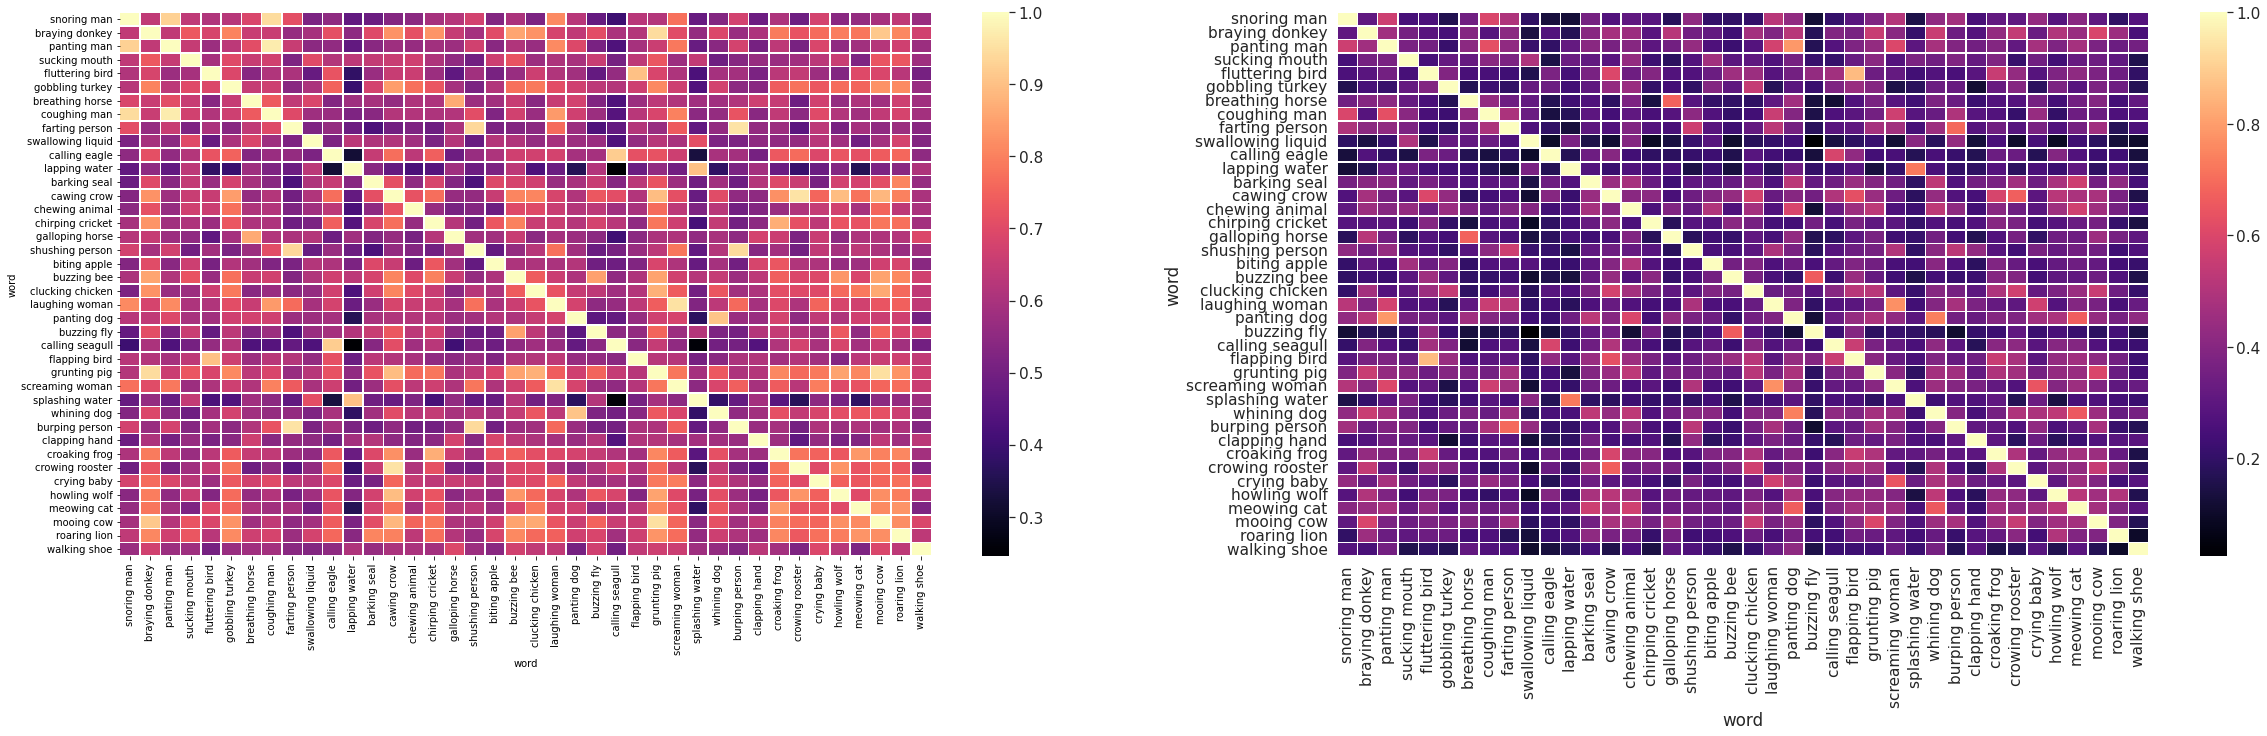

In [10]:
import seaborn as sns

plt.figure(figsize=(40, 10))

plt.subplot(121)
sns.set(font_scale=1.4)
sns.heatmap(mech_ful_ani, 
            linecolor='white', 
            linewidth=0.5,
            xticklabels=viz.index,
            yticklabels=viz.index,
            cmap='magma');

plt.subplot(122)
sns.set(font_scale=1.4)
sns.heatmap(w2v_ani, 
            linecolor='white', 
            linewidth=0.5,
            xticklabels=viz.index,
            yticklabels=viz.index,
            cmap='magma');

plt.savefig("MasterThesis_Results/heatmap.png", facecolor="white", transparent=False, bbox_inches="tight")
plt.show()

The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets. Unlike the Pearson correlation, the Spearman correlation **does not assume that both datasets are normally distributed**. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
<br><br>
The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
<br><br>
<b>Intuitive explanation</b>: <br>We take the upper triangle of the cosine similarity matrix (40x40 = 1600 entries; 1600 / 2 = 800 and removing the diagonal of 1.0s => 800-40 = 760 units in a triangle). Each of the entries in the triangle gives us a number of how similar certain sounds are judged to each other, from which we can calculate a ranking. This ranking is then compared for the embedding-based CSM and the behavioral-based CSM, to see how similar their rankings are, i.e. how similar sounds are evaluated by the model and by the human participants.<br>
<i>Sample size N = 760

## True Correlation Coefficients (Spearman Rho) and P-values

In [11]:
import scipy.stats as stats
import math

def permutation_testing(m1, m2):
    """Nonparametric permutation testing Monte Carlo"""
    np.random.seed(0)
    rhos = []
    n_iter = 5000
    true_rho, _ = stats.spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for iter in range(n_iter):
      np.random.shuffle(m_ids) # shuffle list 
      r, _ = stats.spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
      rhos.append(r)
    perm_p = ((np.sum(np.abs(true_rho) <= np.abs(rhos)))+1)/(n_iter+1) # two-tailed test

    n = 760
    stderr = 1.0 / math.sqrt(n - 3)
    delta = 1.96 * stderr
    ci = true_rho - math.tanh(math.atanh(true_rho) - delta)

    return round(true_rho, 2), round(perm_p, 3), round(ci, 3)

In [ ]:
results = [
    permutation_testing(bert_ina, bruno_ina),
    permutation_testing(w2v_ina, bruno_ina),
    permutation_testing(nomech_ina, bruno_ina),
    permutation_testing(mech_ina, bruno_ina),
    permutation_testing(mech_red_ina, bruno_ina),
    permutation_testing(mech_ful_ina, bruno_ina),
    permutation_testing(vgg_ina, bruno_ina),
    permutation_testing(yamnet_ina, bruno_ina),

    permutation_testing(bert_ani, bruno_ani),
    permutation_testing(w2v_ani, bruno_ani),
    permutation_testing(nomech_ani, bruno_ani),
    permutation_testing(mech_ani, bruno_ani),
    permutation_testing(mech_red_ani, bruno_ani),
    permutation_testing(mech_ful_ani, bruno_ani),
    permutation_testing(vgg_ani, bruno_ani),
    permutation_testing(yamnet_ani, bruno_ani)
]

## Calculating CIs for Rhos
https://stats.stackexchange.com/questions/18887/how-to-calculate-a-confidence-interval-for-spearmans-rank-correlation

In [ ]:
import math
from math import log as ln
from math import sqrt as root
from math import exp as exp
from scipy.stats import zscore as z

# z-score
def z(r):
  zr = 0.5*ln((1+r)/(1-r))
  return zr
# function to create confidence intervals
def ci(r):
  n = 760
  zr = (z(r))
  zu = zr + (z(1-0.5/2)*root((1+(r**2/2))/((n-3))))
  # inverse transform to correlation scale
  ru = (exp(2*zu)-1) / (exp(2*zu)+1)
  return ru - r

In [ ]:
ci(0.4)

In [ ]:
cis = [ci(r[0]) for r in results]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

bar_width = 0.35
x = np.arange(8)

ina_corr = [i[0] for i in results[:8]]
ani_corr = [i[0] for i in results[8:]]
ina_err = [i[2] for i in results[:8]]
ani_err = [i[2] for i in results[8:]]
pvalues = [round(x[1], 3) for x in results]


ina = ax.bar(x, ina_corr, bar_width, label='Inanimate', color = 'black', edgecolor = "black", yerr = ina_err)
ani = ax.bar(x+bar_width+0.1, ani_corr, bar_width, label='Animate', color = 'white', edgecolor = "black", yerr = ani_err)

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel("Spearman's rank correlation coefficient", fontsize=16)
ax.set_title("All correlations with behavioral similarity matrices", fontsize=20)

# fixing x-axes
ax.set_xticks(x+(bar_width+0.1)/2)
ax.set_xticklabels(["S-BERT", "Word2Vec", "Nomech", "Mech", "Red_source", "Ful_source", "VGGish", "YAMNet"], fontsize=16)
ax.tick_params(bottom=False, left=True)

ax.legend(fontsize= 16)
    
# Add annotation to bars
ind = 0
for i in ax.patches:
  if pvalues[ind] == 0.0:
    plt.text(i.get_x(), i.get_height()+0.005,
          #f"r = {str(i.get_height())}\nCI = {confidence_intervals[ind]}\np < 0.001",
          f"r = {str(i.get_height())}\np < 0.001",
          fontsize = 10)
  else:
    plt.text(i.get_x(), i.get_height()+0.005,
          #f"r = {str(i.get_height())}\nCI = {str(confidence_intervals[ind])}\np = {str(pvalues[ind])}",
          f"r = {str(i.get_height())}\np = {str(pvalues[ind])}",
          fontsize = 10)
  ind += 1

plt.grid(False)
plt.show()

fig.savefig('MasterThesis_Results/All_correlations_behavioral_data_2.png', facecolor="white", transparent=False)

Problem: our cell values are non-independent, as changing one row would change all the others.

Fisher's r to z transformation is a statistical method that converts a Pearson product-moment correlation coefficient to a standardized z score in order to assess whether the correlation is statistically different from zero.<br>
https://python-code.pro/spearman-correlation-and-fisher-z-with-python/

## Comparing Dependent Rhos
In the field chapter they mention that you can do a t-statistic to test whether a difference between two dependent correlations from the same sample is significant (in both cases we compare to the behavioral data, thus the correlations are not independent)

In [ ]:
from math import sqrt

# def corr_diff(r1, r2):
#   # Fisher r to Z transformation
#   n = 760
#   z1 = np.arctanh(r1)
#   z2 = np.arctanh(r2)
#   zobs = (z1-z2) / sqrt( abs ( (1 / n-3) + (1 / n-3) ) )
#   return zobs

def corr_diff(r1, r2, r3):
  n = 760
  # t-difference equation taken from Andy Field
  tdiff = (r1 - r2) * sqrt( abs((n-3)*(1+r1) / 2*(1 - r1**2 - r3**2 - r2**2 + 2*r1*r2*r3)) )
  return round(tdiff, 2)

## Hypothesis II Testing
Hypothesis II states that adding the hasMechanism object property will increase the correlation of the ontology based CSM with human behavioral data, i.e. nomech vs mech.

In [ ]:
print("Testing Hypothesis II:\nAdding object properties linking the specific SoundAction to the corresponding SoundMechanism will increase the correlation with human behavioral data, which relies both on semantic and acoustic sound features")

# animate
print("Diff: nomech-bruno - mech-bruno -> ani")
print(corr_diff(
    permutation_testing(mech_ani, bruno_ani)[0],
    permutation_testing(nomech_ani, bruno_ani)[0],
    permutation_testing(mech_ani, nomech_ani)[0],
))

# inanimate
print("Diff: nomech-bruno - mech-bruno -> ina")
print(corr_diff(
    permutation_testing(mech_ina, bruno_ina)[0],
    permutation_testing(nomech_ina, bruno_ina)[0],
    permutation_testing(mech_ina, nomech_ina)[0],
))

# animate + inanimate
print("Diff: nomech-bruno - mech-bruno -> ina + ani")
print(corr_diff(
    permutation_testing(mech_ani, bruno_ani)[0] + permutation_testing(mech_ina, bruno_ina)[0],
    permutation_testing(nomech_ani, bruno_ani)[0] + permutation_testing(nomech_ina, bruno_ina)[0],
    permutation_testing(mech_ani, nomech_ani)[0] + permutation_testing(mech_ina, nomech_ina)[0]
))

## Hypothesis III Testing
III.	Adding a hierarchy of sound sources and averaging both the embeddings for nouns and verbs in the sound description will further increase the correlation with human behavioral data.
mech vs. red_source & mech vs. ful_source

In [ ]:
print("Testing Hypothesis III - reduced source:")

# animate
print("Diff: red_source-bruno - mech_bruno -> ani")
print(corr_diff(
    permutation_testing(mech_red_ani, bruno_ani)[0],
    permutation_testing(mech_ani, bruno_ani)[0],
    permutation_testing(mech_red_ani, mech_ani)[0],
))

# inanimate
print("Diff: red_source-bruno - mech_bruno -> ina")
print(corr_diff(
    permutation_testing(mech_red_ina, bruno_ina)[0],
    permutation_testing(mech_ina, bruno_ina)[0],
    permutation_testing(mech_red_ina, mech_ina)[0],
))

# animate + inanimate
print("Diff: red_source-bruno - mech_bruno -> ina + ani")
print(corr_diff(
    permutation_testing(mech_red_ani, bruno_ani)[0] + permutation_testing(mech_red_ina, bruno_ina)[0],
    permutation_testing(mech_ani, bruno_ani)[0] + permutation_testing(mech_ina, bruno_ina)[0],
    permutation_testing(mech_red_ani, mech_ani)[0] + permutation_testing(mech_red_ina, mech_ina)[0]
))

In [ ]:
print("Testing Hypothesis III - full source:")

# animate
print("Diff: ful_source-bruno - mech-bruno -> ani")
print(corr_diff(
    permutation_testing(mech_ful_ani, bruno_ani)[0],
    permutation_testing(mech_ani, bruno_ani)[0],
    permutation_testing(mech_ful_ani, mech_ani)[0],
))

# inanimate
print("Diff: ful_source-bruno - mech-bruno -> ina")
print(corr_diff(
    permutation_testing(mech_ful_ina, bruno_ina)[0],
    permutation_testing(mech_ina, bruno_ina)[0],
    permutation_testing(mech_ful_ina, mech_ina)[0],
))

# animate + inanimate
print("Diff: ful_source-bruno - mech-bruno -> ina + ani")
print(corr_diff(
    permutation_testing(mech_ful_ani, bruno_ani)[0] + permutation_testing(mech_ful_ina, bruno_ina)[0],
    permutation_testing(mech_ani, bruno_ani)[0] + permutation_testing(mech_ina, bruno_ina)[0],
    permutation_testing(mech_ful_ani, mech_ani)[0] + permutation_testing(mech_ful_ina, mech_ina)[0]
))

In [ ]:
print("Diff: nomech-bruno - mech-bruno -> ani")
print(round(corr_diff(
          stats.spearmanr(upper(nomech_ani), upper(bruno_ani))[0],
          stats.spearmanr(upper(w2v_ani), upper(bruno_ani))[0],
          stats.spearmanr(upper(nomech_ani), upper(w2v_ani))[0],
          ), 2))

print("Diff: nomech-bruno - yamnet-bruno -> ina")
print(round(corr_diff(
          stats.spearmanr(upper(nomech_ina), upper(bruno_ina))[0],
          stats.spearmanr(upper(yamnet_ina), upper(bruno_ina))[0],
          stats.spearmanr(upper(yamnet_ina), upper(nomech_ina))[0]
          ), 2))

print("Diff: mech-bruno - w2v-bruno -> ani")
print(round(corr_diff(
          stats.spearmanr(upper(mech_ani), upper(bruno_ani))[0],
          stats.spearmanr(upper(w2v_ani), upper(bruno_ani))[0],
          stats.spearmanr(upper(w2v_ani), upper(mech_ani))[0]
          ), 2))

print("Diff: mech-bruno - yamnet-bruno -> ina")
print(round(corr_diff(
          stats.spearmanr(upper(mech_ina), upper(bruno_ina))[0],
          stats.spearmanr(upper(yamnet_ina), upper(bruno_ina))[0],
          stats.spearmanr(upper(yamnet_ina), upper(mech_ina))[0]
          ), 2))


print("Diff: mech_red-bruno - w2v-bruno -> ani")
print(round(corr_diff(
          stats.spearmanr(upper(mech_red_ani), upper(bruno_ani))[0],
          stats.spearmanr(upper(w2v_ani), upper(bruno_ani))[0],
          stats.spearmanr(upper(w2v_ani), upper(mech_red_ani))[0]
          ), 2))

print("Diff: mech_red-bruno - yamnet-bruno -> ina")
print(round(corr_diff(
          stats.spearmanr(upper(mech_red_ina), upper(bruno_ina))[0],
          stats.spearmanr(upper(yamnet_ina), upper(bruno_ina))[0],
          stats.spearmanr(upper(yamnet_ina), upper(mech_red_ina))[0]
          ), 2))


print("Diff: mech_ful-bruno - w2v-bruno -> ani")
print(round(corr_diff(
          stats.spearmanr(upper(mech_ful_ani), upper(bruno_ani))[0],
          stats.spearmanr(upper(w2v_ani), upper(bruno_ani))[0],
          stats.spearmanr(upper(w2v_ani), upper(mech_ful_ani))[0]
          ), 2))

print("Diff: mech-bruno - yamnet-bruno -> ina")
print(round(corr_diff(
          stats.spearmanr(upper(mech_ful_ina), upper(bruno_ina))[0],
          stats.spearmanr(upper(yamnet_ina), upper(bruno_ina))[0],
          stats.spearmanr(upper(yamnet_ina), upper(mech_ful_ina))[0]
          ), 2))
                

## Plotting Permutation Testing

In [ ]:
import matplotlib.pyplot as plt

def permutation_testing(m1, m2, title):
    """Nonparametric permutation testing Monte Carlo"""
    np.random.seed(0)
    rhos = []
    n_iter = 5000
    true_rho, _ = stats.spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for iter in range(n_iter):
      np.random.shuffle(m_ids) # shuffle list 
      r, _ = stats.spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
      rhos.append(r)
    perm_p = ((np.sum(np.abs(true_rho) <= np.abs(rhos)))+1)/(n_iter+1) # two-tailed test

    f,ax = plt.subplots()
    plt.hist(rhos,bins=20)
    ax.axvline(true_rho,  color = 'r', linestyle='--')
    if perm_p < 0.001:
      ax.set(title=f"{title}\nTrue rho: {true_rho:.3f}\nPermuted p < 0.001", ylabel="counts", xlabel="rho")
    else:
      ax.set(title=f"{title}\nTrue rho: {true_rho:.3f}\nPermuted p: {perm_p:.3f}", ylabel="counts", xlabel="rho")
    
    plt.show()

    #plt.savefig(f"MasterThesis_Results/Permutations/{title}_perm.png", facecolor="white", transparent=False)

In [ ]:
# permutation_testing((bert_ani),(bruno_ani), "bert_ani"),
# permutation_testing((w2v_ani),(bruno_ani), "w2v_ani"),
# permutation_testing((nomech_ani),(bruno_ani), "nomech_ani"),
# permutation_testing((mech_ani),(bruno_ani), "mech_ani"),
# permutation_testing((mech_red_ani),(bruno_ani), "mech_red_ani"),
# permutation_testing((mech_ful_ani),(bruno_ani), "mech_ful_ani"),
# permutation_testing((vgg_ani),(bruno_ani), "vggish_ani"),
# permutation_testing((yamnet_ani),(bruno_ani), "yamnet_ani")

# permutation_testing((bert_ina),(bruno_ina), "bert_ina"),
# permutation_testing((w2v_ina),(bruno_ina), "w2v_ina"),
# permutation_testing((nomech_ina),(bruno_ina), "nomech_ina"),
# permutation_testing((mech_ina),(bruno_ina), "mech_ina"),
# permutation_testing((mech_red_ina),(bruno_ina), "mech_red_ina"),
# permutation_testing((mech_ful_ina),(bruno_ina), "mech_ful_ina"),
# permutation_testing((vgg_ina),(bruno_ina), "vggish_ina"),
# permutation_testing((yamnet_ina),(bruno_ina), "yamnet_ina")

In [ ]:
ani_corr2 = [
round(stats.spearmanr(upper(mech_ful_ani), upper(bert_ani))[0], 2),
round(stats.spearmanr(upper(mech_ful_ani), upper(w2v_ani))[0], 2),
round(stats.spearmanr(upper(mech_ful_ani), upper(bruno_ani))[0], 2),
round(stats.spearmanr(upper(mech_ful_ani), upper(vgg_ani))[0], 2),
round(stats.spearmanr(upper(mech_ful_ani), upper(yamnet_ani))[0], 2),
]
ina_corr2 = [
round(stats.spearmanr(upper(mech_ful_ina), upper(bert_ina))[0], 2),
round(stats.spearmanr(upper(mech_ful_ina), upper(w2v_ina))[0], 2),
round(stats.spearmanr(upper(mech_ful_ina), upper(bruno_ina))[0], 2),
round(stats.spearmanr(upper(mech_ful_ina), upper(vgg_ina))[0], 2),
round(stats.spearmanr(upper(mech_ful_ina), upper(yamnet_ina))[0], 2),
]

In [ ]:
pvalues2 = [
round(stats.spearmanr(upper(mech_ful_ani), upper(bert_ani))[1], 3),
round(stats.spearmanr(upper(mech_ful_ani), upper(w2v_ani))[1], 3),
round(stats.spearmanr(upper(mech_ful_ani), upper(bruno_ani))[1], 3),
round(stats.spearmanr(upper(mech_ful_ani), upper(vgg_ani))[1], 3),
round(stats.spearmanr(upper(mech_ful_ani), upper(yamnet_ani))[1], 3),
round(stats.spearmanr(upper(mech_ful_ina), upper(bert_ina))[1], 3),
round(stats.spearmanr(upper(mech_ful_ina), upper(w2v_ina))[1], 3),
round(stats.spearmanr(upper(mech_ful_ina), upper(bruno_ina))[1], 3),
round(stats.spearmanr(upper(mech_ful_ina), upper(vgg_ina))[1], 3),
round(stats.spearmanr(upper(mech_ful_ina), upper(yamnet_ina))[1], 3),
]

In [ ]:
confidence_intervals2 = [
confidence_interval(round(stats.spearmanr(upper(mech_ful_ani), upper(bert_ani))[0], 2)),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ani), upper(w2v_ani))[0], 2)),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ani), upper(bruno_ani))[0], 2)),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ani), upper(vgg_ani))[0], 2)),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ani), upper(yamnet_ani))[0], 2)),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ina), upper(bert_ina))[0], 2)),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ina), upper(w2v_ina))[0], 2)),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ina), upper(bruno_ina))[0], 2)),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ina), upper(vgg_ina))[0], 2)),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ina), upper(yamnet_ina))[0], 2)),
]

In [ ]:
ontology_filename = "mech_ful"

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,16))

bar_width = 0.35
x = np.arange(5)

ina = ax.bar(x, ina_corr2, bar_width, label='Inanimate', color = 'black', edgecolor = "black")
ani = ax.bar(x+bar_width+0.1, ani_corr2, bar_width, label='Animate', color = 'white', edgecolor = "black")

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel("Spearman's rank correlation coefficient", fontsize=16)
ax.set_title(f"Correlations with {ontology_filename} similarity matrices", fontsize=20)

# fixing x-axes
ax.set_xticks(x+bar_width/2)
ax.set_xticklabels(["S-BERT", "Word2Vec", "Behavioral Data", "VGGish", "YAMNet"],  fontsize=16)
ax.tick_params(bottom=False, left=True)

ax.legend(fontsize=14)

# Add annotation to bars
ind = 0
for i in ax.patches:
  if pvalues2[ind] == 0.0:
    plt.text(i.get_x(), i.get_height()+0.005,
        f"r = {str(i.get_height())}\nCI = {confidence_intervals2[ind]}\np < 0.001",
        fontsize = 10)
  else:
    plt.text(i.get_x(), i.get_height()+0.005,
          f"r = {str(i.get_height())}\nCI = {confidence_intervals2[ind]}\np = {pvalues2[ind]}",
          fontsize = 10)
  ind += 1

plt.show()

#fig.savefig("MasterThesis_Results/" + ontology_filename + '-CorrWithbestowl.png', facecolor="white", transparent=False)

In [ ]:
ani_corr_avg = [
round(((stats.spearmanr(upper(mech_ful_ani), upper(bert_ani))[0] + stats.spearmanr(upper(mech_ful_ani), upper(w2v_ani))[0]) / 2), 2),
round(stats.spearmanr(upper(mech_ful_ani), upper(bruno_ani))[0], 2),
round(((stats.spearmanr(upper(mech_ful_ani), upper(vgg_ani))[0] + stats.spearmanr(upper(mech_ful_ani), upper(yamnet_ani))[0]) / 2), 2),
]
ina_corr_avg = [
round(((stats.spearmanr(upper(mech_ful_ina), upper(bert_ina))[0] + stats.spearmanr(upper(mech_ful_ina), upper(w2v_ina))[0]) / 2), 2),
round(stats.spearmanr(upper(mech_ful_ina), upper(bruno_ina))[0], 2),
round(((stats.spearmanr(upper(mech_ful_ina), upper(vgg_ina))[0] + stats.spearmanr(upper(mech_ful_ina), upper(yamnet_ina))[0]) / 2), 2),
]

In [ ]:
pvalues_avg = [
(round(stats.spearmanr(upper(mech_ful_ani), upper(bert_ani))[1], 3) + round(stats.spearmanr(upper(mech_ful_ani), upper(w2v_ani))[1], 3)) / 2,
round(stats.spearmanr(upper(mech_ful_ani), upper(bruno_ani))[1], 3),
(round(stats.spearmanr(upper(mech_ful_ani), upper(vgg_ani))[1], 3) + round(stats.spearmanr(upper(mech_ful_ani), upper(yamnet_ani))[1], 3)) / 2,
(round(stats.spearmanr(upper(mech_ful_ina), upper(bert_ina))[1], 3) + round(stats.spearmanr(upper(mech_ful_ina), upper(w2v_ina))[1], 3)) / 2,
round(stats.spearmanr(upper(mech_ful_ina), upper(bruno_ina))[1], 3),
(round(stats.spearmanr(upper(mech_ful_ina), upper(vgg_ina))[1], 3) + round(stats.spearmanr(upper(mech_ful_ina), upper(yamnet_ina))[1], 3)) / 2,
]

In [ ]:
confidence_intervals_avg = [
confidence_interval((round(stats.spearmanr(upper(mech_ful_ani), upper(bert_ani))[0], 2) + round(stats.spearmanr(upper(mech_ful_ani), upper(w2v_ani))[0], 2)) / 2),
confidence_interval(round(stats.spearmanr(upper(mech_ful_ani), upper(bruno_ani))[0], 2)),
confidence_interval((round(stats.spearmanr(upper(mech_ful_ani), upper(vgg_ani))[0], 2) + round(stats.spearmanr(upper(mech_ful_ani), upper(yamnet_ani))[0], 2)) / 2),
confidence_interval((round(stats.spearmanr(upper(mech_ful_ina), upper(bert_ina))[0], 2) + round(stats.spearmanr(upper(mech_ful_ina), upper(w2v_ina))[0], 2)) / 2), 
confidence_interval(round(stats.spearmanr(upper(mech_ful_ina), upper(bruno_ina))[0], 2)),
confidence_interval((round(stats.spearmanr(upper(mech_ful_ina), upper(vgg_ina))[0], 2) + round(stats.spearmanr(upper(mech_ful_ina), upper(yamnet_ina))[0], 2)) / 2),
]

In [ ]:
ontology_filename = "ful_source"

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 14))

bar_width = 0.35
x = np.arange(3)

ina = ax.bar(x, ina_corr_avg, bar_width, label='Inanimate', color = 'black', edgecolor = "black")
ani = ax.bar(x+bar_width+0.1, ani_corr_avg, bar_width, label='Animate', color = 'white', edgecolor = "black")

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel("Spearman's rank correlation coefficient", fontsize=16)
ax.set_title(f"Correlations with {ontology_filename} similarity matrices", fontsize=20)

# fixing x-axes
ax.set_xticks(x+(bar_width+0.1)/2)
ax.set_xticklabels(["Semantic Embeddings", "Behavioral Data", "Audio Classifier Embeddings"],  fontsize=16)
ax.tick_params(bottom=False, left=True)

ax.legend(fontsize=14)

# Add annotation to bars
ind = 0
for i in ax.patches:
  if pvalues2[ind] == 0.0:
    plt.text(i.get_x(), i.get_height()+0.005,
        #f"r = {str(i.get_height())}\nCI = {confidence_intervals_avg[ind]}\np < 0.001",
        f"r = {str(i.get_height())}\np < 0.001",
        fontsize = 12)
  else:
    plt.text(i.get_x(), i.get_height()+0.005,
          #f"r = {str(i.get_height())}\nCI = {confidence_intervals_avg[ind]}\np = {pvalues_avg[ind]}",
          f"r = {str(i.get_height())}\np = {pvalues_avg[ind]}",
          fontsize = 12)
  ind += 1

plt.show()

fig.savefig("MasterThesis_Results/" + ontology_filename + '-CorrWithbestowl_avg.png', facecolor="white", transparent=False)

In [ ]:
from math import sqrt

def corr_diff(r1, r2, r3):
  n = 760
  # t-difference equation taken from Andy Field
  tdiff = (r1 - r2) * sqrt( ((n-3)*(1+r1)) / 2*(1 - r1**2 - r3**2 - r2**2 + 2*r1*r2*r3) )
  return tdiff

print("Hypothesis 1 testing")
print("Sem vs. Behavior -> Ani")
print(corr_diff(ani_corr_avg[0], ani_corr_avg[1],
                round(((stats.spearmanr(upper(bruno_ani), upper(bert_ani))[0] + stats.spearmanr(upper(bruno_ani), upper(w2v_ani))[0]) / 2), 2)))
print("Behavior vs. Audio -> Ani")
print(corr_diff(ani_corr_avg[1], ani_corr_avg[2],
                round(((stats.spearmanr(upper(bruno_ani), upper(vgg_ani))[0] + stats.spearmanr(upper(bruno_ani), upper(yamnet_ani))[0]) / 2), 2)))
print("Sem vs. Audio -> Ani")
print(corr_diff(ani_corr_avg[0], ani_corr_avg[2],
                (round(((stats.spearmanr(upper(bert_ani), upper(vgg_ani))[0] + stats.spearmanr(upper(bert_ani), upper(yamnet_ani))[0]) / 2), 2) +
                round(((stats.spearmanr(upper(w2v_ani), upper(vgg_ani))[0] + stats.spearmanr(upper(w2v_ani), upper(yamnet_ani))[0]) / 2), 2))) )


print("Sem vs. Behavior -> Ina")
print(corr_diff(ina_corr_avg[0], ina_corr_avg[1],
                round(((stats.spearmanr(upper(bruno_ina), upper(bert_ina))[0] + stats.spearmanr(upper(bruno_ina), upper(w2v_ina))[0]) / 2), 2)))
print("Behavior vs. Audio -> Ina")
print(corr_diff(ina_corr_avg[1], ina_corr_avg[2],
                round(((stats.spearmanr(upper(bruno_ina), upper(vgg_ina))[0] + stats.spearmanr(upper(bruno_ina), upper(yamnet_ina))[0]) / 2), 2)))
print("Sem vs. Audio -> Ina")
print(corr_diff(ina_corr_avg[0], ina_corr_avg[2],
                (round(((stats.spearmanr(upper(bert_ina), upper(vgg_ina))[0] + stats.spearmanr(upper(bert_ina), upper(yamnet_ina))[0]) / 2), 2) +
                round(((stats.spearmanr(upper(w2v_ina), upper(vgg_ina))[0] + stats.spearmanr(upper(w2v_ina), upper(yamnet_ina))[0]) / 2), 2))) )